# Localisation functions

In [75]:
import pandas as pd # used to read the csv
import csv          # used to read the csv
import matplotlib.pyplot as plt
import math
import numpy as np
import random

plt.rcParams["figure.figsize"] = (13,9) # To change plot size

Constants definition

In [102]:
DEBUG = True
VERBOSE_PARTICLE = False # to print infos messages

# Map things
MAP_REAL = [841*2,1189] # [mm] (x,y dimensions of the map, here 2*A0)


# The same for any robot
THYMIO_WHEELBASE = 95 # [mm]
THYMIO_SHAPE =  [[ 55.0, -30.0, -30.0,  55.0,  80.0,  55.0],
                 [-47.5, -47.5,  47.5,  47.5,   0.0, -47.5]]
                # [mm] Shape of the thymio robot, for plots
PROX_POS = [[72,72], [13,-13]] # [mm] (x,y coords of the prox sensors)
WEIGHT_RESAMPLE_THRSH = 0.001
ISLOST_THRSH = 10 # [mm] max standard deviation allowed

# To tune for a robot
SPEED_L_STD = 7 # [thymio units]
SPEED_R_STD = 9 # [thymio units]
SPEED_CONVERSION_FACTOR = 50.13/150 # [from thymio units to mm/ms]
PROX_L_STD = 10 # [thymio units]
PROX_R_STD = 10 # [thymio units]
FEATURE2PROX_L = {'grass' : 320,
                  'road' : 1020,
                  'crossing' : 945}
FEATURE2PROX_R = {'grass' : 226,
                  'road' : 1020,
                  'crossing' : 700}

## Class and functions definition
The maths for the odometry from the wheels speeds is taken from the book "Elements of Robotics" by Mordechai Ben-Ari and Francesco Mondada.
###  Base class (Moving_point)
This class is used to define only once the fuctions for the evolution of a 2 wheeled robot.

In [77]:
class Moving_point:
    '''
    One moving point having the same dynamics as the robot.
    The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] horizontal coordinate of the point. (mm)
    -y: [float] vertical coordinate of the point. (mm)
    -theta: [float] orientation of the point (theta == 0 <=> looks at +x). (rad)
    '''
    def __init__(self, *args, **kwargs):
        # -- Public --
        self.set_coords(*args)
        return     
        
       
    def __repr__(self):
        r = "Current position:\n"
        r += f"x = \t\t{round(self.x,2)}\n" 
        r += f"y = \t\t{round(self.y,2)}\n"
        r += f"theta = \t{round(self.theta,2)}\n"
        return r
    
    
    def get_coords(self):
        '''
        Get the coords as a dict {'x':x, 'y':y, 'theta':theta}.
        
        Arguments:
        - void
        
        Outputs:
        - dict of floats {'x':x, 'y':y, 'theta':theta}
        '''
        return {'x':self.x, 'y':self.y, 'theta':self.theta}
    
    
    def set_coords(self, *args, **kwargs):
        '''
        Set the coordinates.
        
        Arguments:
        - dict of floats {'x':x, 'y':y, 'theta':theta} OR 3 floats x, y, theta
        
        Outputs:
        - void
        '''
        if len(args) == 3:
            self.x = args[0]
            self.y = args[1]
            self.theta = args[2]
        elif len(args) == 1 and type(*args) == dict:
            self.x = args[0]['x']
            self.y = args[0]['y']
            self.theta = args[0]['theta'] 
        else:
            print("Error: Coordiantes must be set either with a dict or with x, y and theta.")
        return
      
    
    def _speed2mmpms(self, speed):
        '''
        Convert Thymio speed into mm/ms.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R], in Thymio units
        
        Output:
        - speed: list of both wheelspeeds [speed_L, speed_R], in mm/ms
        '''
        return [speed[0]*SPEED_CONVERSION_FACTOR, speed[1]*SPEED_CONVERSION_FACTOR]
    
    
    def _apriori_odometry(self, speed, dt):
        speed = self._speed2mmpms(speed)
        dl = speed[0]*dt
        dr = speed[1]*dt
        
        dtheta = (dr-dl)/THYMIO_WHEELBASE
        dc = (dl+dr)/2
        
        self.x += dc*math.cos(self.theta + dtheta/2)
        self.y += dc*math.sin(self.theta + dtheta/2)
        self.theta += dtheta
        self.theta %= 2*math.pi
        return

### Particle filter
The particle class should not be used/accessed outside of this module.
A small library exists [here](https://filterpy.readthedocs.io/en/latest/monte_carlo/resampling.html). A tutorial is [here](https://salzis.wordpress.com/2015/05/25/particle-filters-with-python/). Also, [this YouTube video](https://www.youtube.com/watch?v=aUkBa1zMKv4&ab_channel=AndreasSvensson) explains the principle of the filter.

Pseudocode :
```python
def PARTICLE_FILTERING(e, N, dbn):
    '''
    Short: returns a set of samples for the next time step
    
    inputs: 
    - e, the new incoming evidence
    - N, the number of samples to be maintained
    - dbn, a Dynamic Bayesian Network with prior P(X0), transition model P(X1 | X0), sensor model P(E1 | X1)

    persistent:
    - S, a vector of samples of size N, initially generated from P(X0)

    local variables: 
    - W, a vector of weights of size N
    '''
    for i in range(N):
        # step 1: Transition for each particle
        S[i] = sample from P(X1 | X0 = S[i])

        # step 2: Assign weight to particles given the measurement
        W[i] = P(e | X1 = S[i])

        # step 3: Resample the particles
        S = WEIGHTED-SAMPLE-WITH-REPLACEMENT(N, S, W)
    return S
```

In [78]:
class Particle(Moving_point):
    '''
    One particle representing the robot. The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] horizontal coordinate of the robot. (mm)
    -y: [float] vertical coordinate of the robot. (mm)
    -theta: [float] orientation of the robot (theta == 0 <=> looks at +x). (rad)
    '''
    _w_max = 0
    
    def __init__(self, *args, **kwargs):
        # -- Public --
        super().__init__(*args)
            
        self.w = 1 # weight of the particle
        
    
    def reset_total_weight():
        '''
        Resets the total weight.
        '''
        Particle._w_sum = 0
        Particle._w_max = 0
    
    
    def get_weight(self):
        '''
        Get the weight.
        
        Arguments:
        - void
        
        Outputs:
        - weight (float)
        '''
        return self.w
    
    
    def set_weight(self, weight):
        '''
        Set the weight.
        
        Arguments:
        - weight (float)
        
        Outputs:
        - void
        '''
        self.w = weight
        return
    
    
    def transition(self, speed, dt):
        '''
        Updates the particle from the measured motor speeds.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R]
        - dt: float, time interval between each update, in ms
        
        Output:
        -void
        '''
        if VERBOSE_PARTICLE:
            print("Particle pose is getting updated ...")
        
        # Checking correcti dimensions of the args
        try:
            speed_not_ok = len(speed) != 2
        except:
            speed_not_ok = True
        if speed_not_ok:
            print("'speed' argument is of incorrect type/size.")
            print("\tspeed: list of both wheelspeeds [speed_L, speed_R]")
            return
        if type(dt) != int and type(dt) != float:
            print("'dt' argument is of incorrect type/size.")
            print("\tdt: float, time interval between each update, in ms")
            return
        
        # Add gaussian noise to the speeds
        speed[0] += random.gauss(0, SPEED_L_STD)
        speed[1] += random.gauss(0, SPEED_R_STD)
        
        # Do the transition
        self._apriori_odometry(speed, dt)

        
        # Print infos for debugging
        if VERBOSE_PARTICLE:
            print(f"The speeds are : {self._speed2mmps(speed)}")
            print(f"The particle is at : {self}")
            print("Particle pose has been updated successfully !\n")
        return
    
    
    def weight(self, prox):
        '''
        Updates the particle's weight from the measured ground value.
        The weight computed here is not normalised.
        The weight is the likelyhood of the measured prox w.r.t. the expected prox.

        Arguments:
        - prox: list of both ground proximity sensors (delta) [prox_L, prox_R]
        - dt: float, time interval between each update, in ms

        Output:
        -void
        '''
        # Compute weight (assume the prox noise is gaussian)
        mp = np.array(prox) # measured prox
        ep = np.array(expected_prox(self.get_coords())) # expected prox
        dp = mp-ep
        self.w = math.exp(-(dp[0]**2/PROX_L_STD + dp[1]**2/PROX_R_STD)/2)        
        
        # Update weight sum
        Particle._w_sum += self.w
        
        # Update max weight
        if self.w > Particle._w_max:
            Particle._w_max = self.w
        return
    
    
    def plot(self, plot_theta=True):
        SCALING_THETAS_PLOT = 1

        # Creating end point to plot theta
        theta_dx = SCALING_THETAS_PLOT*math.cos(self.theta)
        theta_dy = SCALING_THETAS_PLOT*math.sin(self.theta)

        # Plotting the circle
        if Particle._w_max > 1e-15: # to avoid division by zero  
            plt.scatter(self.x, self.y, marker='.', s=300*(self.w/Particle._w_max), alpha=0.3)
        else:
            plt.scatter(self.x, self.y, marker='.', s=300*(0.1), alpha=0.3)

        # Plotting theta arrow
        if plot_theta:
            plt.arrow(self.x, self.y, theta_dx, theta_dy, width=0.1, head_width=1, alpha=0.2)

        return

### Pose of the robot
The pose of the robot is the interface for the global code.

In [79]:
class Pose(Moving_point):
    '''
    Class for the pose of the robot. The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] Most probable horizontal coordinate of the robot. (mm)
    -y: [float] Most probable vertical coordinate of the robot. (mm)
    -theta: [float] Most probable orientation of the robot (theta == 0 <=> looks at +x). (rad)
    -isLost: [bool] If the localisation gets too imprecise, isLost == True
    '''
    def __init__(self, x, y, theta, isLost=False, nb_particles=100):
        # -- Public --
        super().__init__(x, y, theta)
        self.isLost = isLost
        
        # Initialisation of the particle filter
        self._particles = []
        self._weights = []

        for i in range(nb_particles):
            myParticle = Particle(self.get_coords())
            self._particles.append(myParticle.get_coords())
            self._weights.append(myParticle.get_weight())
        
     
    def update(self, speed, prox, dt):
        '''
        Updates the pose from the displacement and sensors values.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R]
        - prox: list of both ground.delta [prox_1, prox_2]
        - dt: float, time interval between each update, in ms
        
        Output:
        -void
        '''
        if DEBUG:
            print("Pose is getting updated ...")
            print('Initial coords :')
            print(self)
        
        # Checking correcti dimensions of the args
        try:
            speed_not_ok = len(speed) != 2
            prox_not_ok = len(prox) != 2
        except:
            speed_not_ok = True
            prox_not_ok = True
        if speed_not_ok:
            print("'speed' argument is of incorrect type/size.")
            print("\tspeed: list of both wheelspeeds [speed_L, speed_R]")
            return
        if prox_not_ok:
            print("'prox' argument is of incorrect type/size.")
            print("\tprox: list of both ground.delta [prox_1, prox_2]")
            return
        if type(dt) != int and type(dt) != float:
            print("'dt' argument is of incorrect type/size.")
            print("\tdt: float, time interval between each update, in ms")
            return
        
        # Do update using coord
        self._apriori_odometry(speed, dt)
        
        # Update particles
        self._update_particles(speed, prox, dt)
        
        # Update position from the particles (weighted average of the particle)
        if max(self._weights) > 0:
            xs = [self._particles[i]['x'] for i in range(len(self._particles))]
            xs = np.array(xs)
            ys = [self._particles[i]['y'] for i in range(len(self._particles))]
            ys = np.array(ys)
            thetas = [self._particles[i]['theta'] for i in range(len(self._particles))]
            thetas = np.array(thetas)

            self.x = np.sum(xs*np.array(self._weights)) / sum(self._weights)
            self.y = np.sum(ys*np.array(self._weights)) / sum(self._weights)
            self.theta = np.sum(thetas*np.array(self._weights)) / sum(self._weights)

            # Check if lost
            distance_to_particles = [math.sqrt(xs[i]**2 + ys[i]**2) for i in range(len(self._particles))]
            if np.std(distance_to_particles) >= ISLOST_THRSH or max(self._weights) > 0:
                self.isLost = True
                if DEBUG:
                    print('Lost because of particle spread')
            else:
                self.isLost = False
        else:
            self.isLost = True
            if DEBUG:
                print('Lost because w = 0.')
        
        # Print infos for debugging
        if DEBUG:
            print(f"The speeds are : {self._speed2mmpms(speed)}")
            print(f"The prox are : {prox}")
            print("Pose has been updated successfully !\n")
        return
    
    
    def plot(self, plot_theta=True, theta_size=1, plot_particles=True):
        '''
        Plots the current pose and the particles.
        '''
        # Plotting the particles
        if plot_particles:
            for i in range(len(self._particles)):
                myParticle = Particle(self._particles[i])
                myParticle.set_weight(self._weights[i])
                myParticle.plot(plot_theta=plot_theta)
        
        # Creating end points to plot thetas
        theta_dx = theta_size*math.cos(self.theta)
        theta_dy = theta_size*math.sin(self.theta)

        # Plotting the pose of the thymio
        pts = range(len(THYMIO_SHAPE[0]))
        #    rotate the shape
        thy_x = [THYMIO_SHAPE[0][i]*math.cos(self.theta) - THYMIO_SHAPE[1][i]*math.sin(self.theta) for i in pts]
        thy_y = [THYMIO_SHAPE[0][i]*math.sin(self.theta) + THYMIO_SHAPE[1][i]*math.cos(self.theta) for i in pts]
        #    shift the shape
        thy_x = [thy_x[i] + self.x for i in pts]
        thy_y = [thy_y[i] + self.y for i in pts]
        if self.isLost:
            plt.scatter(self.x, self.y, marker='o', color='red', s=100)
            plt.plot(thy_x, thy_y, color='red')
        else:
            plt.scatter(self.x, self.y, marker='o', color='green', s=100)
            plt.plot(thy_x, thy_y, color='green')
            
        # Plotting the prox locations
        pts = range(len(PROX_POS[0]))
        #    rotate the shape
        thy_x = [PROX_POS[0][i]*math.cos(self.theta) - PROX_POS[1][i]*math.sin(self.theta) for i in pts]
        thy_y = [PROX_POS[0][i]*math.sin(self.theta) + PROX_POS[1][i]*math.cos(self.theta) for i in pts]
        #    shift the shape
        thy_x = [thy_x[i] + self.x for i in pts]
        thy_y = [thy_y[i] + self.y for i in pts]
        plt.scatter(thy_x, thy_y, marker='o', color='red', s=100)

        # Plotting theta arrow
        if plot_theta:
            plt.arrow(self.x, self.y, theta_dx, theta_dy, color='orange', width=0.1*theta_size, head_width=0.5*theta_size)
        
        return
    
     
    def _update_particles(self, speed, prox, dt):
        Particle.reset_total_weight()
        for i in range(len(self._particles)):
            myParticle = Particle(self._particles[i])
    
            # Transition
            myParticle.transition(speed, dt)
            self._particles[i] = myParticle.get_coords()
            
            # Compute raw weights
            myParticle.weight(prox)
            
            self._weights[i] = myParticle.get_weight()

        # Resampling the particles
        # resample only when the weights are diverse
        if np.std(self._weights) >= WEIGHT_RESAMPLE_THRSH/math.sqrt(len(self._weights)):
            print(f"Weights are : {self._weights}\nSum weight is {Particle._w_sum}")
            idxs = [i for i in range(len(self._particles))]
            idxs = random.choices(idxs, weights=self._weights, k=len(self._particles))
            self._particles = [self._particles[i] for i in idxs]
            print(f"New idxs : {idxs}")
            print('Resampling done !\n')
        
        return

## Map functions

In [80]:
file_CSV = open('output/roads.csv')
reader = csv.reader(file_CSV)
roads = list(reader)

file_CSV = open('output/passage.csv')
reader = csv.reader(file_CSV)
passage = list(reader)

myMap = {'road': roads,
         'crossing': passage}

In [81]:
def mm2map(coord,map_shape):
    '''
    Converts the coord from mm to map coordinates.
    map_shape = [max_x, max_y]
    '''
    return [int(coord[i]/MAP_REAL[i]*map_shape[i]) for i in range(len(coord))]


def expected_prox(*args, **kwargs):
    '''
    Computes the expected prox values for a point (in mm) on the map.
    
    Arguments:
    - dict of floats {'x':x, 'y':y, 'theta':theta} OR 3 floats x, y, theta
    '''    
    # Extract the points of interest (POI)
    loc = Moving_point(*args).get_coords()
    pts = range(len(PROX_POS[0]))
    #    rotate the shape
    POI_x = [PROX_POS[0][i]*math.cos(loc['theta']) - PROX_POS[1][i]*math.sin(loc['theta']) for i in pts]
    POI_y = [PROX_POS[0][i]*math.sin(loc['theta']) + PROX_POS[1][i]*math.cos(loc['theta']) for i in pts]
    #    shift the shape
    POI_x = [POI_x[i] + loc['x'] for i in pts]
    POI_y = [POI_y[i] + loc['y'] for i in pts]
    
    # Determine what kind of feature is at the POI
    myMap_max = [len(myMap['road']), len(myMap['road'][0])]
    POI_map = [mm2map([POI_x[i], POI_y[i]], myMap_max) for i in range(2)]
    feature = ['grass', 'grass']
    for i in pts:
        idx_x = POI_map[i][0]
        idx_y = POI_map[i][1]
        if idx_x >= myMap_max[0] or idx_x < 0 or idx_y >= myMap_max[1] or idx_y < 0:
            idx_x %= myMap_max[0]
            idx_y %= myMap_max[1]
            print('Warning : Robot (or Particle) ground sensors are out of the map !')
            print('\tContinue working as if the map repeats.')
            
        if myMap['road'][idx_x][idx_y] == 1:
            feature[i] = 'road'
        elif myMap['crossing'][idx_x][idx_y] == 1:
            feature[i] = 'crossing'
        else:
            feature[i] = 'grass'
            
    # Associate the feature to a prox value
    expected_prox = [FEATURE2PROX_L[feature[0]], FEATURE2PROX_R[feature[1]]]
    
    
    return expected_prox

# Obstacle Avoidance functions

In [82]:
import tdmclient.notebook
await tdmclient.notebook.start()

## Obstacle avoidance side chosing function
function used to determine from which side we should avoid an obstacle when we detect one

In [83]:
def proximity_cost(prox_horiz, left_side):
    
    '''compute the cost related to the value measured by the proximity sensors when chosing a side
       or the other when in front of an obstacle. If the proximity sensors on have a high value 
       compared to the other, the cost of chosing that side will be higher than chosing the other side
       
       Arguments: prox_horiz : array containing the value of the 7 horizontal prox sensors
                  left_side  : bool: is true if we want to check the cost of chosing the left side
                                     false if we want the cost of chosing the right side
                                     
      Return:     cost associated to the proximity sensor
    '''
    
    #weight of proximitys
    alpha = 0.004
    
    #to evaluate which side is the closest to the obstacle we just do the sum of the two left most proximity sensor and same 
    #for the right, we then simply do the sum
    
    left_prox_sum = prox_horiz[0]+prox_horiz[1]
    right_prox_sum = prox_horiz[3]+prox_horiz[4]
    
    if left_prox_sum>right_prox_sum:
        if left_side:
            return alpha*abs(left_prox_sum-right_prox_sum)
        else:
            return 0
    else:
        if left_side:
            return 0
        else:
            return alpha*abs(left_prox_sum-right_prox_sum)

In [84]:
def goal_side_cost(tm_pos, tm_orient, goal_pos, left_side):
    """compute the cost related to the position of the thymio with respect to it's next goal
       when chosing a side or the other when in front of an obstacle.
       Chosing a side that takes us to away from the next goal results in a higher cost
       
       Arguments: tm_pos     : array with the position coordinates of the thymio
                  tm_orient  : double containing the orientation of the Thymio in rad in 0-2*pi
                  goal_pos   : array with position of the goal     
                  left_side  : bool: is true if we want to check the cost of chosing the left side
                               false if we want the cost of chosing the right side
                                     
      Return:     cost 
    """
    
    
    
    
    #checking if the Thymio is rather oriented along the x or the y axis and pointing to + or - the x pr y axis
    x_oriented_pos = False
    x_oriented_neg = False
    y_oriented_neg = False
    y_oriented_pos = False
    
    if (tm_orient >= 7*math.pi/4 and tm_orient <= 2*math.pi) or (tm_orient <= math.pi/4 and tm_orient >= 0):  
        x_oriented_pos = True
    
    if (tm_orient >= 3*math.pi/4 and tm_orient <= 5*math.pi/4):
        x_oriented_neg = True
    
    if (tm_orient > math.pi/4 and tm_orient < 3*math.pi/4):
        y_oriented_pos = True
    
    if (tm_orient > 5*math.pi/4 and tm_orient < 7*math.pi/4):
        y_oriented_neg = True
    
    
    #computation of the cost
    Betha = 12
    
    #check which of the Thymio or the goal position has the larger x and y coordinate
    x_goal_larger = goal_pos[0] > tm_pos[0]
    y_goal_larger = goal_pos[1] > tm_pos[1]
    
    if x_oriented_pos:
        if y_goal_larger:
            if left_side:
                return 0
            else:
                return Betha*abs(tm_pos[1]-goal_pos[1])
        else:
            if left_side:
                 return Betha*abs(tm_pos[1]-goal_pos[1])
            else:
                return 0
    
        
    if x_oriented_neg:
        if y_goal_larger:
            if left_side:
                return Betha*abs(tm_pos[1]-goal_pos[1])
            else:
                return 0
        else:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[1]-goal_pos[1])
    
        
    if y_oriented_pos:
        if x_goal_larger:
            if left_side:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
            else:
                return 0
        else:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
    
    if y_oriented_neg:
        if x_goal_larger:
            if left_side:
                return 0
            else:
                 return Betha*abs(tm_pos[0]-goal_pos[0])
    

In [85]:
def total_cost(goal_pos, tm_pos, tm_orient, prox_horiz, left_side):
    '''
       compute the cost of chosing a side rather than the other when in front of an obstacle

       Arguments: tm_pos     : array with the position coordinates of the thymio
                  tm_orient  : double containing the orientation of the Thymio in rad in 0-2*pi
                  goal_pos   : array with position of the goal     
                  left_side  : bool: is true if we want to check the cost of chosing the left side
                               false if we want the cost of chosing the right side 
                  prox_horiz : array containing the value of the 7 horizontal prox sensors
       
       Return:    total cost
       
    '''
    
    prox_cost = proximity_cost(prox_horiz, left_side)

    goal_cost = goal_side_cost(tm_pos, tm_orient, goal_pos, left_side)
    
    return prox_cost + goal_cost

In [86]:
#returns a bool left_side = 1 if the result is to choose the left direction
def choose_direction(prox_horiz, goal_pos, tm_pos, tm_orient):
    """
        choose on which direction we should go when in front of an obstacle
        
        Arguments: prox_horiz : array of horizontal proximity sensors values
                   goal_pos   : array of coordinated of the goal position
                   tm_pos     : array of coordinates of the thymio position
                   tm_orient  : double of the thymio orientation in rad in 0-2pi
        Returns:   left_side  : bool that is true if we should go to the left side, false if should go
                                to the right side.
    """
    left_side = False
    
    left_cost = total_cost(goal_pos, tm_pos, tm_orient, prox_horiz, True)
    
    right_cost = total_cost(goal_pos, tm_pos, tm_orient, prox_horiz, False)
        
    if left_cost < right_cost:
        left_side = True

    return left_side

##  Obstacle avoidance/following functions

In [87]:
def obstacle_detected(proximity_sensor, OBST_THRESH=2000):
    """
        determine if an obstacle is detected by the proximity sensor provided in the argument
        
        Arguments: proximity_sensor: double containing the value of the inquired sensor
                   OBST_THRESH     : threshold at which we consider an obstacle is detected
        Return:    obstacle        : bool, True if an obstacle is detected, False otherwise
    """

    obstacle = False
    
    if proximity_sensor >= OBST_THRESH:
            obstacle = True
    
    return obstacle


In [88]:
def path_to_goal_free(tm_orient, tm_pos, goal_pos, proximity_sensors):
    """
        determines if in the general direction of the goal, i.e. left, right or front, an obstacle 
        is in the way, hence if the path to goal is free.
        
        Argument:  tm_orient  : double of the thymio orientation in rad in 0-2pi
                   tm_pos     : array of coordinates of the thymio position
                   proximity_sensors : array of horizontal proximity sensors values
                   goal_pos   : array of coordinated of the goal position
                       
    """
    
    #the goal direction is obstacle free
    goal_clear = True
    
    #determine where is the obstacle with respect to the Thymio
    goal_front = False
    goal_right = False
    goal_left = False
    
    #We start by getting the angle between the x-axis and the vector connecting the goal to the thymio
    theta = math.atan2(goal_pos[1]-tm_pos[1], goal_pos[0]-tm_pos[0])
    
    if theta < 0:
        theta += math.pi*2
        
    
    #checking position of goal with respect to thymio view angle
    
    #We start by checking if the thymio is in the visibility of the proximity sensors view angle
    if tm_orient >= math.pi/4 and tm_orient <= 7*math.pi/4:
        
        
        if theta >= tm_orient-math.pi/4 and theta <= tm_orient+math.pi/4:
            goal_front = True
            #print("FRONT1")
            
            
    if tm_orient >= 0 and tm_orient < math.pi/4:
        
        if (theta >= 0 and theta <= tm_orient+math.pi/4) or (theta>= 7*math.pi/4):
            goal_front = True
            #print("FRONT2")
    
    if tm_orient > 7*math.pi/4:
        
        if (theta >= tm_orient-math.pi/4) or (theta <= tm_orient- 7*math.pi/4):
            goal_front = True
            #print("Front3")
    
    #checking if the goal is on the left or right side of the robot
    if tm_orient <= math.pi and (not goal_front):
        if theta >= tm_orient and theta <=math.pi+tm_orient:
            goal_left = True
            
        else:
            goal_right = True
            #print("Right")
    
    if tm_orient > math.pi and (not goal_front):
        if theta >= tm_orient-math.pi and theta < tm_orient:
            goal_right = True
            #print("left")
        else:
            goal_left = True
            #print("right")
            
    #now that the position of the robot with respect to the robot angle of vision is determined, we can determine if there is an obstacle
    #Threshold for obstacle on the side
    THRESH_SIDE = 1500
    #Threshold for obstacle detection on front
    THRESH_FRONT_CENTRAL = 1500 #Threshold for central prox
    THRESH_FRONT_SIDE = 1700   #Threshold for the prox between central and outest
    THRESH_FRONT_OUTEST = 2000 #Thresjold for outest proximity sensors
    
     
    
    if goal_front:

        if (obstacle_detected(proximity_sensors[2],THRESH_FRONT_CENTRAL) or 
            obstacle_detected(proximity_sensors[3],THRESH_FRONT_SIDE) or
            obstacle_detected(proximity_sensors[1],THRESH_FRONT_SIDE) or
            obstacle_detected(proximity_sensors[0],THRESH_FRONT_OUTEST) or
            obstacle_detected(proximity_sensors[4],THRESH_FRONT_OUTEST)):
            
            goal_clear = False
            #print("obst front")
            
    if goal_left:
        if obstacle_detected(proximity_sensors[0],THRESH_SIDE):
            
            goal_clear = False
            #print("obst left")
    
    if goal_right:
         if obstacle_detected(proximity_sensors[4],THRESH_SIDE):
            
            goal_clear = False
            #print("obst right")
            
    return goal_clear

### PID regulators to follow the obstacle side

In [89]:
#PID controller for following the profile of an obstacle on the right of the robot
past_err2 = 0
past_err3 = 0
past_err4 = 0
past_prox2 = 0
past_prox3 = 0
past_prox4 = 0

def right_obst_follow(reset):
    """
        computes the speed to assign to the thymio motor to follow an obstacle on the right side of
        the Thymio with a PID controller
        
        Argument: reset: bool: true if we must reset the past error terms of the integrator term
                               and reset the past value of the prox sensor for the derivative
                               Typically a reset must be done each time we follow a new obstacle
        return:  2 dim vector containing the speeds to assign to the motor in format (right, left)
    """
    global past_err2, past_err3, past_err4, past_prox2, past_prox3, past_prox4
    
    PROX_SCALING = 200
    
    Prox2_obj = 0
    Prox3_obj = 0
    Prox4_obj = 2000
    speed0 = 150

    #PID constants for each  proximity sensor
    Kp_2 = 6
    Ki_2 = 1
    Kd_2 = -5
    
    Kp_3 = 5
    Ki_3 = 1
    Kd_3 = -3
    
    Kp_4 = 3
    Ki_4 = 1
    Kd_4 = -5
    
    if reset:
        past_err2 = 0
        past_err3 = 0
        past_err4 = 0
        past_prox2 = 0
        past_prox3 = 0
        past_prox4 = 0
    
    #implementation of the proportional controller
    error2 = (Prox2_obj-prox_horizontal[2])
    error3 = (Prox3_obj-prox_horizontal[3])
    error4 = (Prox4_obj-prox_horizontal[4])
    
    speedP2 = (Kp_2*error2)//PROX_SCALING
    
    speedP3 = (Kp_3*error3)//PROX_SCALING
    
    speedP4 = (Kp_4*error4)//PROX_SCALING
    
    #print("speed prop:")
    #print(speedP2)
    #print(speedP3)
    #print(speedP4)
   
    #implementation of the derivative controller
    speedD2 = (Kd_2*(prox_horizontal[2]-past_prox2))//PROX_SCALING
    speedD3 = (Kd_3*(prox_horizontal[3]-past_prox3))//PROX_SCALING
    speedD4 = (Kd_4*(prox_horizontal[4]-past_prox4))//PROX_SCALING
    
    print("Speed derivative:")
    print(speedD2)
    print(speedD3)
    print(speedD4)
   
    
    past_prox2 = prox_horizontal[2]
    past_prox3 = prox_horizontal[3]
    past_prox4 = prox_horizontal[4]
    
    #implementation of the integral term with antireset windup
    speedI2 = Ki_2*past_err2//3
    speedI3 = Ki_3*past_err3//3
    speedI4 = Ki_4*past_err4//3
    
    #print("speed integral")
    #print(speedI2)
    #print(speedI3)
    #print(speedI4)
    
    past_err2 += error2
    past_err3 += error3
    past_err4 += error4
    
    past_error_max = 15
    if past_err2 > past_error_max:
        past_err2 = past_error_max
    if past_err2 < -past_error_max:
        past_err2 = -past_error_max
        
    if past_err3 > past_error_max:
        past_err3 = past_error_max
    if past_err3 < -past_error_max:
        past_err3 = -past_error_max
        
    if past_err4 > past_error_max:
        past_err4 = past_error_max
    if past_err4 < -past_error_max:
        past_err4 = -past_error_max
        
    
    speed_PID = speedP2+speedP3+speedP4+speedD2+speedD3+speedD4+speedI4+speedI2+speedI3
    speed_right = speed0-speed_PID
    #print("speed_right")
    
    #print(speed_right)
    speed_left = speed0+speed_PID
    
    #print("speed_left")
    #print(speed_left)
    
    return [speed_right, speed_left]
    

In [90]:
#PID controller to follow an obstacle on the left
past_err0 = 0
past_err1 = 0
past_err2 = 0
past_prox2 = 0
past_prox1 = 0
past_prox0 = 0

def left_obst_follow(reset):
    """
        computes the speed to assign to the thymio motor to follow an obstacle on the left side of
        the Thymio with a PID controller
        
        Argument: reset: bool: true if we must reset the past error terms of the integrator term
                               and reset the past value of the prox sensor for the derivative
                               Typically a reset must be done each time we follow a new obstacle
        return:  2 dim vector containing the speeds to assign to the motor in format (right, left)
    """
    
    global past_err0, past_err1, past_err2, past_prox2, past_prox1, past_prox0
    
    PROX_SCALING = 200
    
    Prox1_obj = 0
    Prox2_obj = 0
    Prox0_obj = 2000
    speed0 = 150

    #PID constants for each  proximity sensor
    Kp_2 = 6
    Ki_2 = 1
    Kd_2 = -5
    
    Kp_1 = 5
    Ki_1 = 1
    Kd_1 = -3
    
    Kp_0 = 3
    Ki_0 = 1
    Kd_0 = -5
     
    if reset:
        past_err2 = 0
        past_err1 = 0
        past_err0 = 0
        past_prox2 = 0
        past_prox1 = 0
        past_prox0 = 0
    
    #implementation of the proportional controller
    error2 = (Prox2_obj-prox_horizontal[2])
    error1 = (Prox1_obj-prox_horizontal[1])
    error0 = (Prox0_obj-prox_horizontal[0])
    
    speedP2 = (Kp_2*error2)//PROX_SCALING
    speedP1 = (Kp_1*error1)//PROX_SCALING
    speedP0 = (Kp_0*error0)//PROX_SCALING
  
    
    #implementation of the derivative controller
    speedD2 = (Kd_2*(prox_horizontal[2]-past_prox2))//PROX_SCALING
    speedD1 = (Kd_1*(prox_horizontal[1]-past_prox1))//PROX_SCALING
    speedD0 = (Kd_0*(prox_horizontal[0]-past_prox0))//PROX_SCALING
  
    past_prox2 = prox_horizontal[2]
    past_prox1 = prox_horizontal[1]
    past_prox0 = prox_horizontal[0]
    
    #implementation of the integral term with antireset windup
    speedI2 = Ki_2*past_err2//3
    speedI1 = Ki_1*past_err1//3
    speedI0 = Ki_0*past_err0//3

    
    past_err2 += error2
    past_err1 += error1
    past_err0 += error0
    
    past_error_max = 15
    if past_err2 > past_error_max:
        past_err2 = past_error_max
    if past_err2 < -past_error_max:
        past_err2 = -past_error_max
        
    if past_err1 > past_error_max:
        past_err1 = past_error_max
    if past_err1 < -past_error_max:
        past_err1 = -past_error_max
        
    if past_err0 > past_error_max:
        past_err0 = past_error_max
    if past_err0 < -past_error_max:
        past_err0 = -past_error_max
        
 
    speed_PID = speedP2+speedP1+speedP0+speedD2+speedD1+speedD0+speedI1+speedI2+speedI0
    speed_right = speed0+speed_PID
    speed_left = speed0-speed_PID
    

    
    return [speed_right, speed_left]
    
   

# fusion of localisation and obstacle avoidance

In [121]:
#putting everything together
#putting together functions
obstacle = False
ITER_PATH_FREE = 9 #number of iteration where the path to the goal is free before we stop following the obstacle
speeds_init = 120
motor_left_target = speeds_init
motor_right_target = speeds_init
pose = Pose(500,500,0)
pose.set_coords(500, 500, 0.00)
position = [0,0]
i = 0
while i <= 30: #not obstacle:
    i += 1
    prox = prox_horizontal
    obstacle = obstacle or obstacle_detected(prox[2], 1500)
    obstacle = obstacle or obstacle_detected(prox[1], 1700)
    obstacle = obstacle or obstacle_detected(prox[3], 1700)
    obstacle = obstacle or obstacle_detected(prox[0], 2500)
    obstacle = obstacle or obstacle_detected(prox[4], 2500)
   
    sleep(0.2)
    prox_grnd = prox_ground_delta
    speeds_meas = [motor_left_speed,motor_right_speed]
    speed2 = [speeds_meas[0]*SPEED_CONVERSION_FACTOR,speeds_meas[1]*SPEED_CONVERSION_FACTOR]
    print("speed meas")
    print(speed2)
    pose.update(speeds_meas, prox_grnd, 0.2)
    position = [position[0]+0.2*speed2[0]+speed2[1]/2,0]

motor_left_target = 0
motor_right_target = 0
"""
prox_horiz = prox_horizontal


coords = pose.get_coords()
print("coord 1")
print(coords)
Go_left = choose_direction(prox_horiz, (1500, 0), (coords['x'],coords['y']), coords['theta'])

follow_obst = True
prox_grnd = prox_ground_delta
sleep(0.3)
pose.update([speeds_init,speeds_init], prox_grnd, 300)
coords = pose.get_coords()
print("coord2")
print(coords)

reset = True
i = 0  #count number of iteration in the loop
free_path_iter = 0 #number of consecutive iteration with a clear path
speeds = [0,0]
while follow_obst:    
    
    prox = prox_horizontal
    print(prox)
    if i != 0:
        reset = False
    
    if Go_left:
        #if turn left obstacle is on the rigth
        speeds = right_obst_follow(reset)
        motor_right_target = speeds[0]
        motor_left_target = speeds[1]
        #print("LEFT")
        
    else:
        speeds_and_err = left_obst_follow(reset)
        motor_right_target = speeds_and_err[0]
        motor_left_target = speeds_and_err[1]
    
  
    coords = pose.get_coords()
    print("coords3")
    print(coords)
    
    if path_to_goal_free(coords['theta'], (coords['x'],coords['y']), (800,500),prox):
        free_path_iter += 1
        #print("FREE")
        
        if free_path_iter > ITER_PATH_FREE:
                follow_obst = False
    else:
        free_path_iter = 0
        #print("not free")
    
    print("iter")
    print(free_path_iter)
    
    i += 1
    sleep(0.3)
    prox_grnd = prox_ground_delta
    
    pose.update([motor_left_speed,motor_right_speed], prox_grnd, 300)
    coords = pose.get_coords()
    print("coord 4")
    print(coords)
    
sleep(0.3)


motor_left_target = 0
motor_right_target = 0
#pose.plot()
"""

speed meas
[0.0, 0.0]
Pose is getting updated ...
Initial coords :
Current position:
x = 		500
y = 		500
theta = 	0.0

Lost because of particle spread
The speeds are : [-31.889961257761875, 12.497102904860473]
The prox are : [294, 209]
Pose has been updated successfully !

speed meas
[31.749, 34.7568]
Pose is getting updated ...
Initial coords :
Current position:
x = 		499.07
y = 		500.0
theta = 	2.72

Lost because of particle spread
The speeds are : [5.6591121854334, -33.75778616873608]
The prox are : [293, 209]
Pose has been updated successfully !

speed meas
[45.4512, 37.4304]
Pose is getting updated ...
Initial coords :
Current position:
x = 		501.56
y = 		499.96
theta = 	3.44

Lost because of particle spread
The speeds are : [39.259209716948824, 84.23695702394075]
The prox are : [294, 209]
Pose has been updated successfully !

speed meas
[42.4434, 36.762]
Pose is getting updated ...
Initial coords :
Current position:
x = 		511.31
y = 		499.92
theta = 	2.89

Lost because of particl

speed meas
[39.7698, 39.4356]
Pose is getting updated ...
Initial coords :
Current position:
x = 		725.19
y = 		530.19
theta = 	0.46

Lost because of particle spread
The speeds are : [52.79935014044437, 75.49640527915774]
The prox are : [298, 210]
Pose has been updated successfully !

speed meas
[41.4408, 41.4408]
Pose is getting updated ...
Initial coords :
Current position:
x = 		735.81
y = 		533.09
theta = 	0.54

Lost because of particle spread
The speeds are : [29.57652687316783, 10.503676144396692]
The prox are : [297, 210]
Pose has been updated successfully !



'\nprox_horiz = prox_horizontal\n\n\ncoords = pose.get_coords()\nprint("coord 1")\nprint(coords)\nGo_left = choose_direction(prox_horiz, (1500, 0), (coords[\'x\'],coords[\'y\']), coords[\'theta\'])\n\nfollow_obst = True\nprox_grnd = prox_ground_delta\nsleep(0.3)\npose.update([speeds_init,speeds_init], prox_grnd, 300)\ncoords = pose.get_coords()\nprint("coord2")\nprint(coords)\n\nreset = True\ni = 0  #count number of iteration in the loop\nfree_path_iter = 0 #number of consecutive iteration with a clear path\nspeeds = [0,0]\nwhile follow_obst:    \n    \n    prox = prox_horizontal\n    print(prox)\n    if i != 0:\n        reset = False\n    \n    if Go_left:\n        #if turn left obstacle is on the rigth\n        speeds = right_obst_follow(reset)\n        motor_right_target = speeds[0]\n        motor_left_target = speeds[1]\n        #print("LEFT")\n        \n    else:\n        speeds_and_err = left_obst_follow(reset)\n        motor_right_target = speeds_and_err[0]\n        motor_left_t

In [114]:
motor_left_target = 0
motor_right_target = 0


In [122]:
position

[823.2348599999999, 0]

Current position:
x = 		553.09
y = 		499.27
theta = 	6.25



True

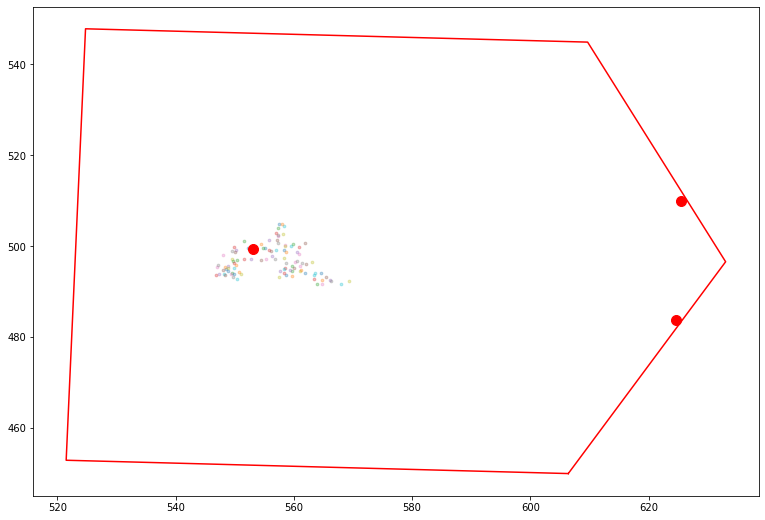

In [106]:
print(pose)
pose.plot(plot_theta=False)
pose.isLost

In [52]:
prox_ground_delta

[305, 226]